## BERT  
BERT (Bidirectional Encoder Representations from Transformers)

Pre-training of Deep Bidirectional Trnasformers for Language Understanding

2018년 구글에서 개발한 NLP(자연어처리) 사전 훈련 기술이며, 특정 분야에 국한된 기술이 아니라 모든 자연어 처리 분야에서 좋은 성능을 내는 범용 Language Model이다. 11개 이상의 자연어처리 과제에서 BERT가 최첨단 성능을 발휘한다고 하지만 그 이유는 잘 알려져 있지 않다. 하지만 BERT는 이전까지 자연어처리에 활용하였던 앙상블 모델보다 더 좋은 성능을 내고 있어서 많은 관심을 받고 있는 언어모델이다.  

BERT는 '사전 훈련 언어모델' 이다. 특정 과제를 수행하기 위한 모델의 성능은, 데이터가 충분히 많다면 Embedding이 큰 영향을 미친다. 단어의 의미를 잘 표현하는 벡터로 표현하는 Embedding된 단어들이 훈련과정에서 좋은 성능을 낸다. 이 임베딩 과정에서 BERT를 사용한다.  

출처: https://ebbnflow.tistory.com/151

## KoBERT  
Korean BERT (Bidirectional Encoder Representations from Transformers)

KoBERT는 기존 BERT의 한국어 성능 한계를 극복하기 위해 SKTBrain에서 개발하였다. 위키피디아나 뉴스 등에서 수집한 수백만 개의 한국어 문장으로 이루어진 대규모말뭉치(corpus)를 학습하였으며, 한국어의 불규칙한 언어 변화의 특성을 반영하기 위해 데이터 기반 토큰화(Tokenization) 기법을 적용하여 기존 대비 27%의 토큰만으로 2.6% 이상의 성능 향상을 이끌어 냈다.  

대량의 데이터를 빠른시간에 학습하기 위해 링 리듀스(ring-reduce) 기반 분산 학습 기술을 사용하여, 십억 개 이상의 문장을 다수의 머신에서 빠르게 학습한다. 더불어, 파이토치(PyTorch), 텐서플루(TensorFlow), ONNX, MXNet을 포함한 다양한 딥러닝 API를 지원함으로써, 많은 분야에서 언어 이해 서비스 확산에 기여하고 있다.  

출처 : https://sktelecom.github.io/project/kobert/


### KoBERT GitHub  
https://github.com/SKTBrain/KoBERT

## KoBERT를 이용한 영화 리뷰 감성 분석

참고 : https://tech-diary.tistory.com/31

In [1]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3
!pip install torch

     |████████████████████████████████| 46.9 MB 41 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 7.8 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595716 sha256=cc3a628fa32e576ecb4681658470ae4e629d29708403214997f77e6216b85b62
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 1.2 MB 8.1 MB/s 
     |████████████████████████████████| 754 kB 8.6 MB/s 
     |████████████████████████████████| 3.0 MB 54.4 MB/s 
     |████████████████████████████████| 895 kB 61.7 MB/s 


In [2]:
# KoBERT 다운로드

!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-imc_o0r3
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-imc_o0r3
  Created wheel for kobert: filename=kobert-0.1.2-py3-none-any.whl size=12770 sha256=85f8065f0c0469aebd6e2c3f159dfdc6f3490af5ac64149f3024ccc13a9abe56
  Stored in directory: /tmp/pip-ephem-wheel-cache-9cpy_h8n/wheels/d3/68/ca/334747dfb038313b49cf71f84832a33372f3470d9ddfd051c0
Successfully built kobert


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [4]:
# KoBERT 모듈 불러오기

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

In [5]:
# GPU 사용

device = torch.device("cuda:0")

In [6]:
# KoBERT 모델 가져오기

bertmodel, vocab = get_pytorch_kobert_model()

[██████████████████████████████████████████████████]
[██████████████████████████████████████████████████]


In [7]:
# 웹에서 영화 리뷰 데이터 가져오기

!wget https://www.dropbox.com/s/374ftkec978br3d/ratings_train.txt?dl=1
!wget https://www.dropbox.com/s/977gbwh542gdy94/ratings_test.txt?dl=1

--2021-08-11 09:14:51--  https://www.dropbox.com/s/374ftkec978br3d/ratings_train.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/374ftkec978br3d/ratings_train.txt [following]
--2021-08-11 09:14:51--  https://www.dropbox.com/s/dl/374ftkec978br3d/ratings_train.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce1e4a9cbc4713c6248cc8e9178.dl.dropboxusercontent.com/cd/0/get/BUCeHML2x4KwNBgnESJOxkvKfkRC0CEOBh-WP91PJrOdi1rWxTbN-pNcubSnn3QVEFN67RMEMP26pUEz8P7ZD3xbPMwnOoRkTpyJmHA58PeKcn1WsBbAa0WnEf7XlgOhUfgPTcEVqreOkkLzzApEcZzt/file?dl=1# [following]
--2021-08-11 09:14:52--  https://uce1e4a9cbc4713c6248cc8e9178.dl.dropboxusercontent.com/cd/0/get/BUCeHML2x4KwNBgnESJOxkvKfkRC0CEOBh-WP91PJrOdi1rWxTbN-pNcubSnn3QVEFN67RMEM

In [8]:
# 가져온 데이터 변수로 저장

dataset_train = nlp.data.TSVDataset("ratings_train.txt?dl=1", field_indices=[1,2], num_discard_samples=1)    # 가져올 데이터에 따라 TSVDataset의 파라미터 설정
dataset_test = nlp.data.TSVDataset("ratings_test.txt?dl=1", field_indices=[1,2], num_discard_samples=1)

In [9]:
# 데이터 형태 : [ text , label ]
# label : 긍정:1 / 부정:0

dataset_train[:10]

[['아 더빙.. 진짜 짜증나네요 목소리', '0'],
 ['흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', '1'],
 ['너무재밓었다그래서보는것을추천한다', '0'],
 ['교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정', '0'],
 ['사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다', '1'],
 ['막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.', '0'],
 ['원작의 긴장감을 제대로 살려내지못했다.', '0'],
 ['별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네',
  '0'],
 ['액션이 없는데도 재미 있는 몇안되는 영화', '1'],
 ['왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?', '1']]

In [10]:
# 토큰화 함수 (KoBERT의 tokenizer와 vocab를 gluonnlp의 BERTSPTokenizer에 적용)

tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


In [11]:
# tokenizer를 이용하여 데이터의 문장과 label을 변환

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    # 슬라이싱 가능하도록 설정
    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    # len 함수 사용 가능하도록 설정
    def __len__(self):
        return (len(self.labels))

In [12]:
# 파리미터 설정

max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [13]:
# 토큰화

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [14]:
data_train[0]

(array([   2, 3093, 1698, 6456,  517,   54,  517,   54, 4368, 4396, 7316,
        5655, 5703, 2073,    3,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(15, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 0)

In [15]:
# label 값

data_train[0][-1]

0

In [16]:
print(len(data_train))
print(len(data_test))

150000
50000


In [17]:
# dataloader 사용 ( dataset에서 하나씩 불러오는 방식 : 메모리 효율 UP )

train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [18]:
# 모델 구성

class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,    # dropout rate (dropout시 제외하는 뉴런 비율)
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [19]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

In [20]:
# warmup 사용

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

### warmup  
VAE에서 쓰이는 기법  
학습 초반에는 reconstruction error만을 사용하고, 학습이 진행될수록 점점 loss 함수에서 KL-divergence의 비중을 늘려줌  
이 기법을 사용함으로써 VAE에서 latent unit이 inactive 되는 문제를 완화

In [21]:
# 최적화 / 손실함수

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [22]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [23]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [24]:
# acuuracy 계산 함수

def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [25]:
# 모델 학습

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 0.7049439549446106 train acc 0.546875
epoch 1 batch id 201 loss 0.42404699325561523 train acc 0.6040111940298507
epoch 1 batch id 401 loss 0.46788299083709717 train acc 0.6973971321695761
epoch 1 batch id 601 loss 0.43497350811958313 train acc 0.7433184276206323
epoch 1 batch id 801 loss 0.4445204436779022 train acc 0.7681803995006242
epoch 1 batch id 1001 loss 0.3062879741191864 train acc 0.7842938311688312
epoch 1 batch id 1201 loss 0.3229128122329712 train acc 0.7964586802664446
epoch 1 batch id 1401 loss 0.2888447940349579 train acc 0.8048046038543897
epoch 1 batch id 1601 loss 0.3200254738330841 train acc 0.8121584166146159
epoch 1 batch id 1801 loss 0.2553779184818268 train acc 0.8184949333703498
epoch 1 batch id 2001 loss 0.34655722975730896 train acc 0.8238068465767117
epoch 1 batch id 2201 loss 0.2796371281147003 train acc 0.8283876646978646

epoch 1 train acc 0.8316246267064846


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epoch 1 test acc 0.8842311381074168


epoch 2 batch id 1 loss 0.4741913974285126 train acc 0.8125
epoch 2 batch id 201 loss 0.21602119505405426 train acc 0.8792754975124378
epoch 2 batch id 401 loss 0.25388461351394653 train acc 0.8820137157107232
epoch 2 batch id 601 loss 0.3761311173439026 train acc 0.8862572795341098
epoch 2 batch id 801 loss 0.3655208647251129 train acc 0.8884792446941323
epoch 2 batch id 1001 loss 0.27672794461250305 train acc 0.890625
epoch 2 batch id 1201 loss 0.190463125705719 train acc 0.8936823480432973
epoch 2 batch id 1401 loss 0.29264217615127563 train acc 0.8962236795146324
epoch 2 batch id 1601 loss 0.35455918312072754 train acc 0.8981398344784509
epoch 2 batch id 1801 loss 0.13833564519882202 train acc 0.8998039283731261
epoch 2 batch id 2001 loss 0.19773046672344208 train acc 0.9019318465767117
epoch 2 batch id 2201 loss 0.23514506220817566 train acc 0.9029986369831895

epoch 2 train acc 0.9042257714732651



epoch 2 test acc 0.890005594629156


epoch 3 batch id 1 loss 0.4286215305328369 train acc 0.84375
epoch 3 batch id 201 loss 0.12000185996294022 train acc 0.9219527363184079
epoch 3 batch id 401 loss 0.20514096319675446 train acc 0.9233556733167082
epoch 3 batch id 601 loss 0.29784703254699707 train acc 0.9264507071547421
epoch 3 batch id 801 loss 0.2928318381309509 train acc 0.92917056803995
epoch 3 batch id 1001 loss 0.14401866495609283 train acc 0.9309440559440559
epoch 3 batch id 1201 loss 0.047339580953121185 train acc 0.9335709825145712
epoch 3 batch id 1401 loss 0.16249017417430878 train acc 0.93510215917202
epoch 3 batch id 1601 loss 0.28382745385169983 train acc 0.9361824640849469
epoch 3 batch id 1801 loss 0.07687043398618698 train acc 0.9376301360355358
epoch 3 batch id 2001 loss 0.22494572401046753 train acc 0.9392178910544727
epoch 3 batch id 2201 loss 0.09659142792224884 train acc 0.9401195479327579

epoch 3 train acc 0.941348478384528



epoch 3 test acc 0.8955003196930946


epoch 4 batch id 1 loss 0.3992646038532257 train acc 0.859375
epoch 4 batch id 201 loss 0.07581786811351776 train acc 0.9560012437810945
epoch 4 batch id 401 loss 0.14028799533843994 train acc 0.9551511845386533
epoch 4 batch id 601 loss 0.2152165174484253 train acc 0.9571547420965059
epoch 4 batch id 801 loss 0.16322217881679535 train acc 0.958586922596754
epoch 4 batch id 1001 loss 0.056972894817590714 train acc 0.9603365384615384
epoch 4 batch id 1201 loss 0.008910943754017353 train acc 0.9612822647793505
epoch 4 batch id 1401 loss 0.12567849457263947 train acc 0.9622925588865097
epoch 4 batch id 1601 loss 0.12913408875465393 train acc 0.96303091817614
epoch 4 batch id 1801 loss 0.06251979619264603 train acc 0.9639436424208773
epoch 4 batch id 2001 loss 0.14537054300308228 train acc 0.9648144677661169
epoch 4 batch id 2201 loss 0.07158637791872025 train acc 0.9653708541572013

epoch 4 train acc 0.9658436433447098



epoch 4 test acc 0.8972386508951407


epoch 5 batch id 1 loss 0.443956196308136 train acc 0.875
epoch 5 batch id 201 loss 0.04097457602620125 train acc 0.9738028606965174
epoch 5 batch id 401 loss 0.06688861548900604 train acc 0.9743999376558603
epoch 5 batch id 601 loss 0.14840936660766602 train acc 0.9746776206322796
epoch 5 batch id 801 loss 0.09277107566595078 train acc 0.9748946629213483
epoch 5 batch id 1001 loss 0.008352939039468765 train acc 0.9759147102897103
epoch 5 batch id 1201 loss 0.014858000911772251 train acc 0.9765169650291424
epoch 5 batch id 1401 loss 0.031942062079906464 train acc 0.976902658815132
epoch 5 batch id 1601 loss 0.08712473511695862 train acc 0.9771236727045597
epoch 5 batch id 1801 loss 0.023773936554789543 train acc 0.9774170599666852
epoch 5 batch id 2001 loss 0.07971938699483871 train acc 0.9777533108445777
epoch 5 batch id 2201 loss 0.08823547512292862 train acc 0.9778367787369378

epoch 5 train acc 0.9781623293515358



epoch 5 test acc 0.8973385549872123


1 epoch
train accuracy : 83.16 %
test  accuracy : 88.42 %

2 epoch
train accuracy : 90.42 %
test  accuracy : 89.0 %

3 epoch
train accuracy : 94.13 %
test  accuracy : 89.55 %

4 epoch
train accuracy : 96.58 %
test  accuracy : 89.72 %

5 epoch
train accuracy : 97.81 %
test  accuracy : 89.73 %



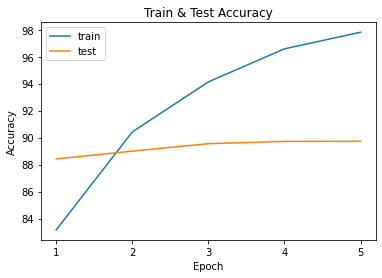

In [30]:
import matplotlib.pyplot as plt

epoch = range(1,6)
acc_train = [83.16,90.42,94.13,96.58,97.81]
acc_test = [88.42,89.00,89.55,89.72,89.73]

for i in epoch:
  print('{} epoch'.format(i))
  print('train accuracy : {} %'.format(acc_train[i-1]))
  print('test  accuracy : {} %'.format(acc_test[i-1]))
  print()

plt.plot(epoch, acc_train, label='train')
plt.plot(epoch, acc_test, label='test')
plt.title('Train & Test Accuracy')
plt.legend()
plt.xticks(epoch)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()